In [4]:
## Choose GPUs and CPUs

#If want to choose GPU to use
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,4"
#This will make it so that only the 0th GPU is visible to TensorFlow.
#In your case, you can choose any in the range [0, 3].
#If you wanted, for example, the 0th and 2nd GPUs to both be visible, replace "0" with "0,2"

import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import mnist

from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.utils import to_categorical, multi_gpu_model, plot_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model

GPU=True
CPU=False
num_cores = 4

if GPU:
    num_GPU = 2
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
session = tf.Session(config=config)
K.set_session(session)

import matplotlib.pyplot as plt
import numpy as np


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline


In [22]:
h,w=32,32
nepochs=10

In [23]:
class ModelMGPU(Model):
    def __init__(self, ser_model, gpus):
        pmodel = multi_gpu_model(ser_model, gpus)
        self.__dict__.update(pmodel.__dict__)
        self._smodel = ser_model

    def __getattribute__(self, attrname):
        '''Override load and save methods to be used from the serial-model. The
        serial-model holds references to the weights in the multi-gpu model.
        '''
        # return Model.__getattribute__(self, attrname)
        if 'load' in attrname or 'save' in attrname:
            return getattr(self._smodel, attrname)

        return super(ModelMGPU, self).__getattribute__(attrname)

In [11]:
real_intens_test=np.load('data_numpy_arrays/real_intens_test.npy')
real_phase_test=np.load('data_numpy_arrays/real_phase_test.npy')
ft_test=np.load('data_numpy_arrays/ft_test.npy')

real_intens_train=np.load('data_numpy_arrays/real_intens_train.npy')
real_phase_train=np.load('data_numpy_arrays/real_phase_train.npy')
ft_train=np.load('data_numpy_arrays/ft_train.npy')
ft_train_unstrained=np.load('data_numpy_arrays/ft_unstrained.npy')

# Autoencoder-structure predictor

In [24]:

K.clear_session()
np.random.seed(123)
model=Sequential()


input_img = Input(shape=(h, w, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
#x = Dropout(0.5)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
#x = Dropout(0.5)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
#encoded = Dropout(0.5)(x)
encoded=x

# at this point the representation is 

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Dropout(0.5)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Dropout(0.5)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Dropout(0.5)(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

parallel_model = ModelMGPU(autoencoder, gpus=num_GPU)
parallel_model.compile(optimizer='adam', loss='binary_crossentropy')

print (autoencoder.summary())
plot_model(autoencoder, to_file='paper_data/str_model.png')

checkpoints=keras.callbacks.ModelCheckpoint('v4_struct_weights/tmp_weights_struct/weights.{epoch:02d}.hdf5', 
                                            monitor='val_loss', verbose=1, save_best_only=False, 
                                            save_weights_only=False, mode='auto', period=1)

history=parallel_model.fit(ft_train, real_intens_train, shuffle=True, batch_size=256, verbose=1, 
                           epochs=nepochs, validation_split = 0.1, callbacks=[checkpoints])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

"\naxarr[1].plot(epochs,hist.history['acc'], 'C0o', label='Training')\naxarr[1].plot(epochs,hist.history['val_acc'], 'C0-', label='Validation')\nplt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.tight_layout()\nplt.grid()\nplt.tick_params(which='both', width=2)\nplt.tick_params(which='major', length=7)\nplt.tick_params(which='minor', length=5)\n"

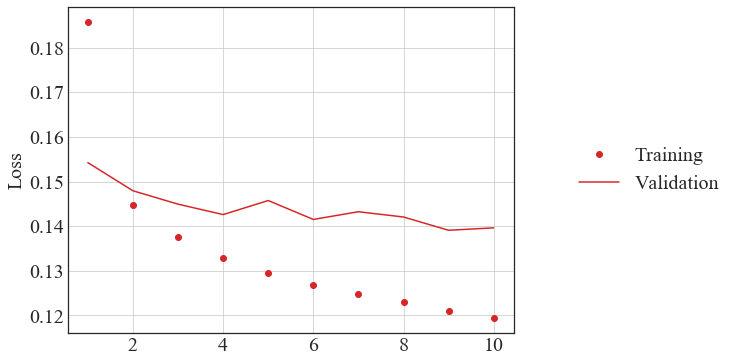

In [25]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(1, sharex=True, figsize=(8, 6))

axarr.set(ylabel='Loss')
axarr.plot(epochs,hist.history['loss'], 'C3o', label='Training')
axarr.plot(epochs,hist.history['val_loss'], 'C3-', label='Validation')
axarr.grid()
axarr.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

"""
axarr[1].plot(epochs,hist.history['acc'], 'C0o', label='Training')
axarr[1].plot(epochs,hist.history['val_acc'], 'C0-', label='Validation')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.grid()
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=5)
"""

In [26]:
np.save('paper_data/str_history', history.history)

In [56]:
minepoch=10
from keras.models import Model, load_model
model=load_model('v4_struct_weights/tmp_weights_struct/weights.%02d.hdf5' %minepoch)
#score=model.evaluate(ft_test, test_dataset, verbose=1)
#print (score)

In [57]:
preds_intens=(model.predict(ft_test))
print (preds_intens.shape)

(10000, 32, 32, 1)


# Use 0.1 as threshold for intensity

In [58]:
preds_intens=np.where(preds_intens<0.1,0,preds_intens)

# Plot some instances of the test data, it's FT and the CNN prediction

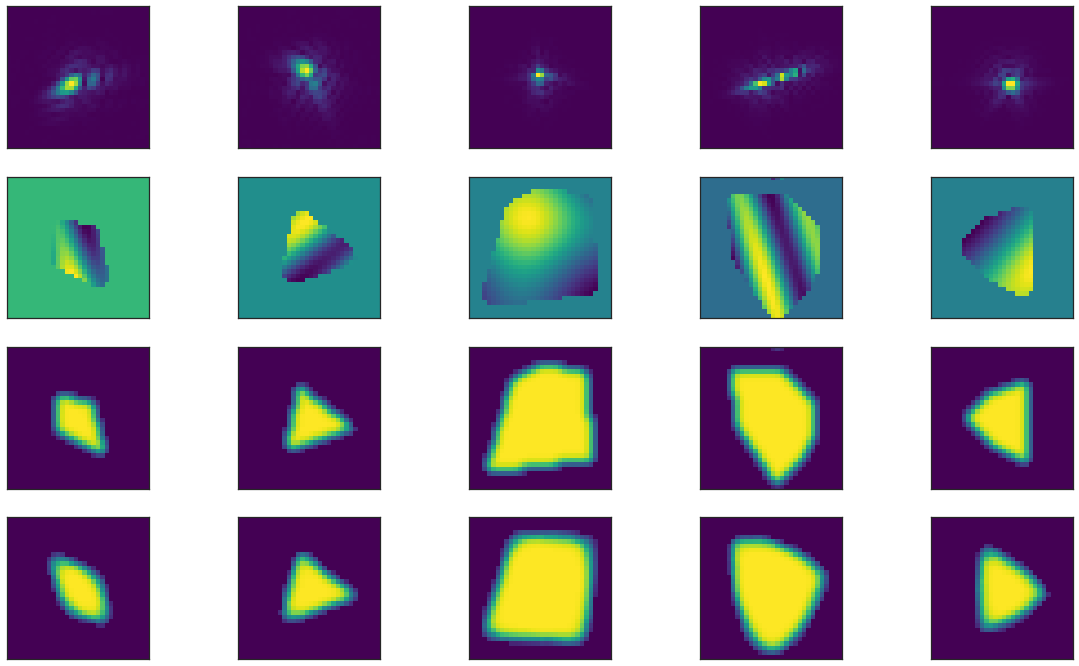

In [59]:
ntrain=120000
ntest=10000
plt.viridis()
n = 5
f,ax=plt.subplots(4,n,figsize=(20, 12))
for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display original intens
    ax[2,i].imshow(real_intens_test[j].reshape(h, w))
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
    # display original intens
    ax[1,i].imshow(real_phase_test[j].reshape(h, w))
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)

    # display FT
    ax[0,i].imshow(ft_test[j].reshape(h, w))
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display reconstruction
    ax[3,i].imshow(preds_intens[j].reshape(h, w))
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.show()

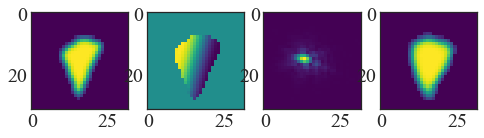

In [60]:
i=0
f,axarr=plt.subplots(1,4,figsize=(8, 6))
axarr[0].imshow(real_intens_test[i].squeeze())
axarr[1].imshow(real_phase_test[i].squeeze())
axarr[2].imshow(ft_test[i].squeeze())
axarr[3].imshow(preds_intens[i].squeeze())

# Autoencoder-predict phase

In [32]:

K.clear_session()
np.random.seed(123)
model=Sequential()


input_img = Input(shape=(h, w, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
#x = Dropout(0.5)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
#x = Dropout(0.5)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
#encoded = Dropout(0.5)(x)
encoded=x

# at this point the representation is 

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Dropout(0.5)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Dropout(0.5)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Dropout(0.5)(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

parallel_model = ModelMGPU(autoencoder, gpus=num_GPU)
parallel_model.compile(optimizer='adam', loss='binary_crossentropy')

print (autoencoder.summary())
plot_model(autoencoder, to_file='paper_data/ph_model.png')


checkpoints=keras.callbacks.ModelCheckpoint('v4_struct_weights/tmp_weights_phase/weights.{epoch:02d}.hdf5', 
                                            monitor='val_loss', verbose=1, save_best_only=False, 
                                            save_weights_only=False, mode='auto', period=1)

history=parallel_model.fit(ft_train, real_phase_train, shuffle=True, batch_size=256, 
                        verbose=1, epochs=nepochs, validation_split = 0.1, callbacks=[checkpoints])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [33]:
np.save('paper_data/ph_history', history.history)

"\naxarr[1].plot(epochs,hist.history['acc'], 'C0o', label='Training')\naxarr[1].plot(epochs,hist.history['val_acc'], 'C0-', label='Validation')\nplt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.tight_layout()\nplt.grid()\nplt.tick_params(which='both', width=2)\nplt.tick_params(which='major', length=7)\nplt.tick_params(which='minor', length=5)\n"

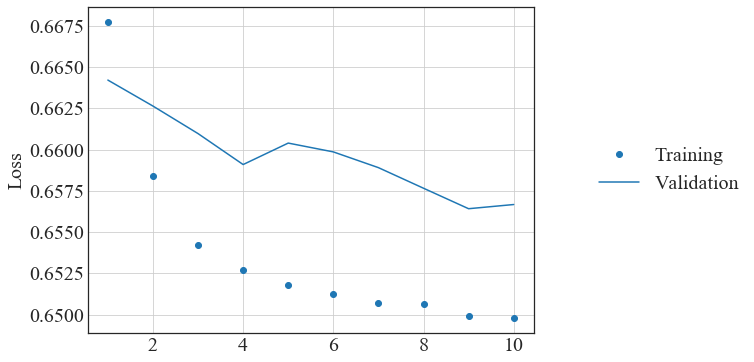

In [43]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(1, sharex=True, figsize=(8, 6))

axarr.set(ylabel='Loss')
axarr.plot(epochs,hist.history['loss'], 'C0o', label='Training')
axarr.plot(epochs,hist.history['val_loss'], 'C0-', label='Validation')
axarr.grid()
axarr.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

"""
axarr[1].plot(epochs,hist.history['acc'], 'C0o', label='Training')
axarr[1].plot(epochs,hist.history['val_acc'], 'C0-', label='Validation')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.grid()
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=5)
"""

In [61]:
minepoch=10
from keras.models import Model, load_model
model=load_model('v4_struct_weights/tmp_weights_phase/weights.%02d.hdf5' %minepoch)
#score=model.evaluate(ft_test, test_dataset, verbose=1)
#print (score)

In [62]:
preds_phase=(model.predict(ft_test))*2*np.pi-np.pi #MAP BACK TO -pi to pi phases
print (preds_phase.shape)

(10000, 32, 32, 1)


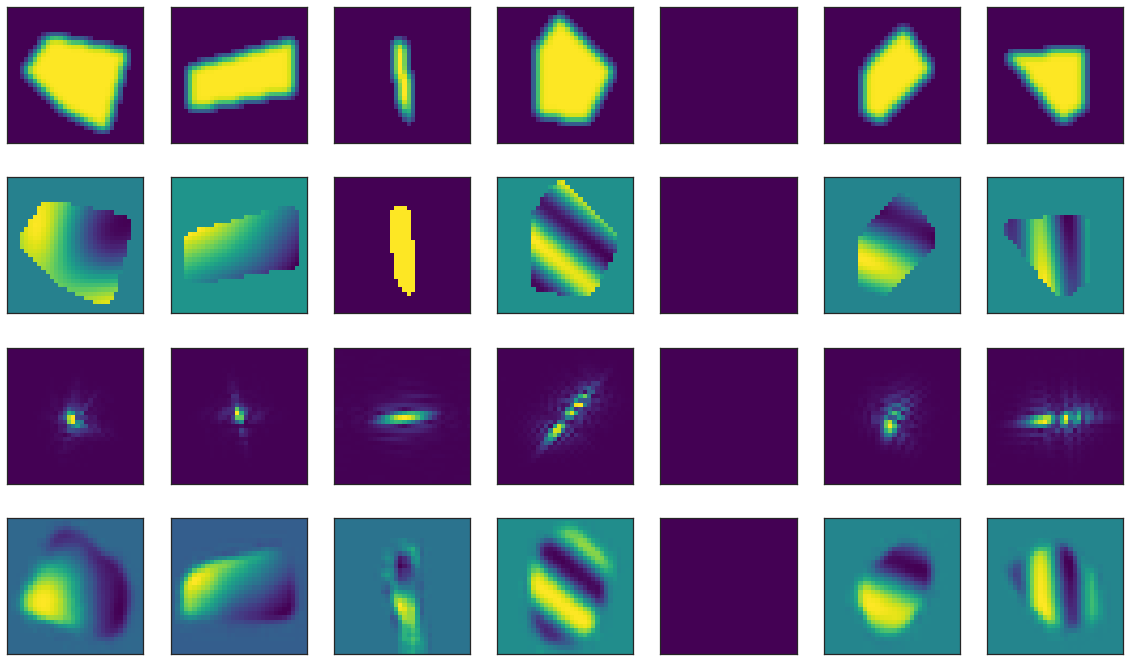

In [63]:
plt.viridis()
n = 7
f,ax=plt.subplots(4,n,figsize=(20, 12))
for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display original intens
    ax[0,i].imshow(real_intens_test[j].reshape(h, w))
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display original intens
    ax[1,i].imshow(real_phase_test[j].reshape(h, w))
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)

    # display FT
    ax[2,i].imshow(ft_test[j].reshape(h, w))
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
    # display reconstruction
    ax[3,i].imshow(preds_phase[j].reshape(h, w))
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.show()

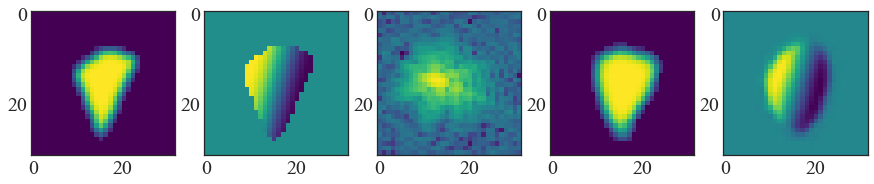

In [64]:
i=0
f,axarr=plt.subplots(1,5,figsize=(15, 10))
axarr[0].imshow(real_intens_test[i].squeeze())
axarr[1].imshow(real_phase_test[i].squeeze())
axarr[2].imshow(np.log10(ft_test[i].squeeze()))
axarr[3].imshow(preds_intens[i].squeeze())
axarr[4].imshow(preds_phase[i].squeeze())

# Zero phase when lying outside the object

In [65]:
preds_phase3=np.where(preds_intens<0.1,0,preds_phase)

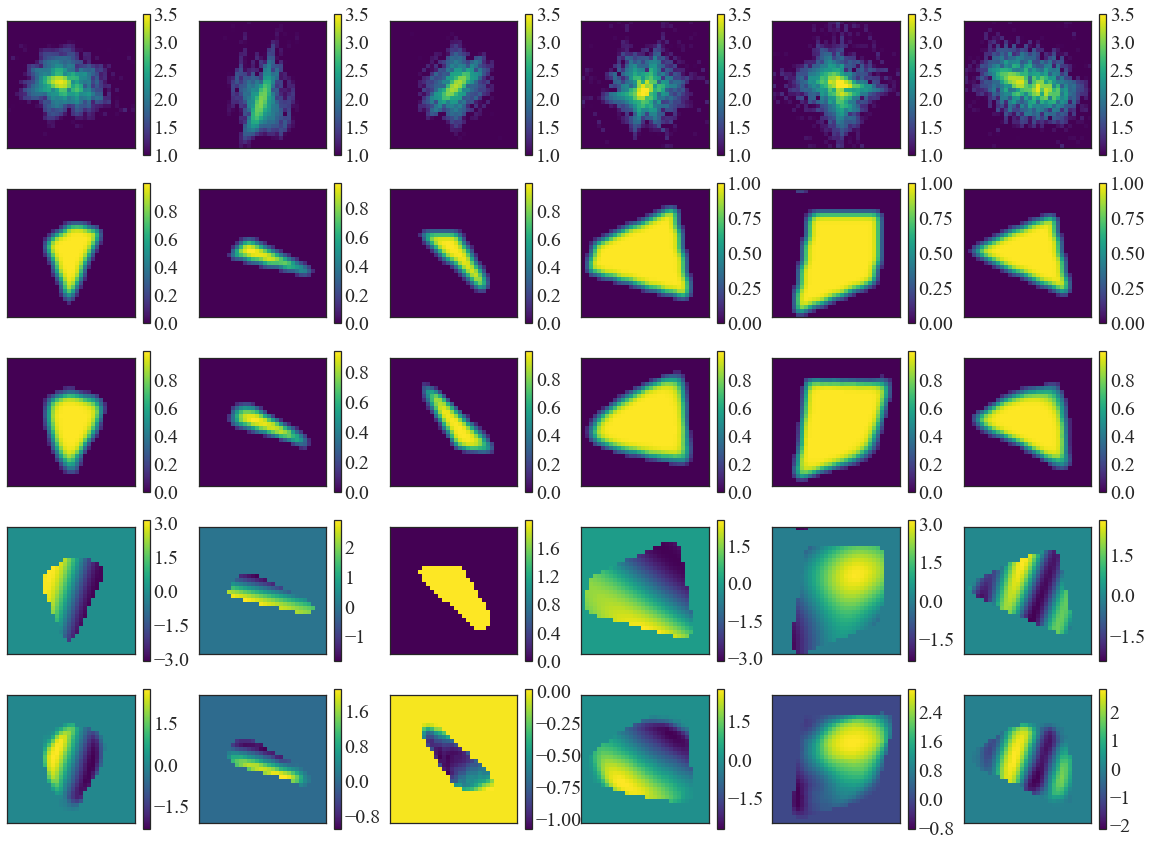

In [66]:
ntest=10000
np.random.seed()
plt.viridis()
n = 6
f,axp=plt.subplots(5,n,figsize=(20, 15))
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)


for i in range(0,n):
    j=int(round(np.random.rand()*ntest))
    # display original intens
    im=axp[1,i].imshow(real_intens_test[j].reshape(h, w))
    axp[1,i].get_xaxis().set_visible(False)
    axp[1,i].get_yaxis().set_visible(False)
    cb=plt.colorbar(im, ax=axp[1,i])
    cb.locator = tick_locator
    cb.update_ticks()
    
    # display original phase
    im=axp[3,i].imshow(real_phase_test[j].reshape(h, w)*2*np.pi-np.pi) #MAP BACK TO -pi to pi phases)
    axp[3,i].get_xaxis().set_visible(False)
    axp[3,i].get_yaxis().set_visible(False)
    cb=plt.colorbar(im, ax=axp[3,i])
    cb.locator = tick_locator
    cb.update_ticks()

    # display FT
    im=axp[0,i].imshow(ft_test[j].reshape(h, w))
#    im=axp[0,i].imshow((ft_test[j].reshape(h, w)))
    axp[0,i].get_xaxis().set_visible(False)
    axp[0,i].get_yaxis().set_visible(False)
    cb=plt.colorbar(im, ax=axp[0,i])
    cb.locator = tick_locator
#    im.set_clim(2,5)
    cb.update_ticks()
    
    # display intens predict
    im=axp[2,i].imshow(preds_intens[j].reshape(h, w))
    axp[2,i].get_xaxis().set_visible(False)
    axp[2,i].get_yaxis().set_visible(False)
    cb=plt.colorbar(im, ax=axp[2,i])
    cb.locator = tick_locator
    cb.update_ticks()
    
    # display reconstruction
    im=axp[4,i].imshow(preds_phase3[j].reshape(h, w))
    axp[4,i].get_xaxis().set_visible(False)
    axp[4,i].get_yaxis().set_visible(False)
    cb=plt.colorbar(im, ax=axp[4,i])
    cb.locator = tick_locator
    cb.update_ticks()
plt.show()

# Test gold data set

In [ ]:
import tifffile as tff
ifile='summededit1crop.tif'
#Read image
im=tff.TiffFile(ifile)
imarr=im.asarray()
imarr=imarr.transpose(2,1,0) #I think the detector is rotated 90?
nx,ny,nz=imarr.shape[0],imarr.shape[1], imarr.shape[2]
print ("Original number of X,Y and Z bins", nx, ny, nz)

#Take only middle slice along Z
imarr=imarr[:,:,nz/2]**0.5
# Crop the junk
imarr=imarr[25:-25,25:-25]
plt.imshow(np.log10(imarr))
plt.colorbar()

In [ ]:
from scipy.ndimage.interpolation import zoom

dims=imarr.shape
imarr2=zoom(imarr,(h/float(dims[0]),w/float(dims[1])))

imarr2=np.reshape(imarr2,(1,h,w,1)) #Reshape to format predictor needs
print (np.max(imarr2))
imarr2=imarr2/np.max(imarr2)*10000
print (np.max(imarr2))

In [ ]:
plt.imshow(np.log10(imarr2.squeeze()))
plt.colorbar()

In [ ]:
str_model=load_model('v4_struct_weights/tmp_weights_struct/weights.10.hdf5')

In [ ]:
tmp_str=str_model.predict(imarr2)
plt.imshow(tmp_str.squeeze())
plt.colorbar()

In [ ]:
ph_model=load_model('v4_struct_weights/tmp_weights_phase/weights.10.hdf5')

In [ ]:
tmp_ph=ph_model.predict(imarr2)*2*np.pi-np.pi
tmp_ph=np.where(tmp_str<0.3, 0, tmp_ph)

In [ ]:
plt.imshow(tmp_ph.squeeze())
plt.colorbar()
#plt.clim(0,5)

In [ ]:
i=500
tmp_str=str_model.predict(ft_train[i].reshape(1,32,32,1))
tmp_str=np.where(tmp_str<0.3,0,tmp_str)
plt.imshow(tmp_str.squeeze())
plt.colorbar()

In [ ]:
plt.imshow(real_intens_train[i].squeeze())